# Passo 2: EDA Sênior - Estrutura Temporal, Causalidade e Não-Linearidade

## Objetivo
Esta análise vai além do básico "Preço sobe, Venda cai". Investigaremos:
1.  **Dinâmica Temporal:** Decomposição de Séries Temporais (Tendência vs Sazonalidade) e FFT.
2.  **Física dos Preços:** Relações não-lineares (Spearman vs Pearson) e Mutual Information.
3.  **Inferência Causal:** Testes de causalidade de Granger e Cross-Correlation.
4.  **Posicionamento de Mercado:** Análise de RPI (Índice de Preço Relativo).

In [10]:

# Cores padrão para gráficos
colors_default = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests, ccf
from sklearn.feature_selection import mutual_info_regression
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


## 1. Análise Temporal Avançada (Decomposição STL e FFT)
Para entender se a variação de vendas é ruído, tendência ou sazonalidade, vamos focar no **Top 1 Produto** (com mais dados).

In [12]:
df

,product_id,product_category_name,month_year,qty,total_revenue,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price,date
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.950000,39,161,2,...,3.9,15.011897,215.000000,4.4,8.760000,45.950000,4.0,15.100000,45.900000,2017-05-01
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.950000,39,161,2,...,3.9,14.769216,209.000000,4.4,21.322000,45.950000,4.0,12.933333,45.950000,2017-06-01
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.950000,39,161,2,...,3.9,13.993833,205.000000,4.4,22.195932,45.950000,4.0,14.840000,45.950000,2017-07-01
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.950000,39,161,2,...,3.9,14.656757,199.509804,4.4,19.412885,45.950000,4.0,14.287500,45.950000,2017-08-01
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.950000,39,161,2,...,3.9,18.776522,163.398710,4.4,24.324687,45.950000,4.0,15.100000,45.950000,2017-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,watches8,watches_gifts,01-04-2018,26,3908.90,17.501923,150.342308,35,640,1,...,4.2,2.181647,105.000000,4.2,13.631429,150.133333,3.8,19.447778,167.500000,2018-04-01
672,watches8,watches_gifts,01-05-2018,30,4355.00,16.259000,145.166667,35,640,1,...,4.2,0.095439,105.000000,4.2,11.377297,132.531250,3.8,15.762187,150.342308,2018-05-01
673,watches8,watches_gifts,01-06-2018,3,457.90,19.170000,152.633333,35,640,1,...,4.2,19.206667,105.000000,4.2,23.823571,138.220000,3.8,16.108000,145.166667,2018-06-01
674,watches8,watches_gifts,01-07-2018,14,2200.00,16.657143,157.142857,35,640,1,...,4.2,15.480000,105.000000,4.2,24.938750,155.000000,3.8,16.470000,152.633333,2018-07-01


In [13]:
# 1.1 Decomposição STL via Spark SQL Data
# Primeiro, identificar o produto Top 1
query_top = "SELECT product_id FROM elastic_price.raw.retail_price GROUP BY product_id ORDER BY count(*) DESC LIMIT 1"
top_prod = spark.sql(query_top).collect()[0]['product_id']
print(f"Analisando Produto Top 1: {top_prod}")

# Pegar dados temporais desse produto
query = f'''
SELECT date, qty 
FROM elastic_price.raw.retail_price 
WHERE product_id = "{top_prod}"
ORDER BY date
'''
df_ts = pd.DataFrame(spark.sql(query).collect(), columns=spark.sql(query).columns)
df_ts['date'] = pd.to_datetime(df_ts['date'])
df_ts['qty'] = df_ts['qty'].astype(float)
df_prod = df_ts.set_index('date').resample('MS').mean().fillna(method='ffill')

decomp = seasonal_decompose(df_prod['qty'], model='additive', period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomp.observed.plot(ax=ax1, title='Série Observada (Vendas)', color=colors_default[0])
decomp.trend.plot(ax=ax2, title='Tendência (Longo Prazo)', color=colors_default[1])
decomp.seasonal.plot(ax=ax3, title='Sazonalidade (Padrão Repetitivo)', color=colors_default[2])
decomp.resid.plot(ax=ax4, title='Resíduo (Ruído/Anomalias)', color=colors_default[3])
plt.tight_layout()
plt.show()

ValueError: x must have 2 complete cycles requires 24 observations. x only has 20 observation(s)

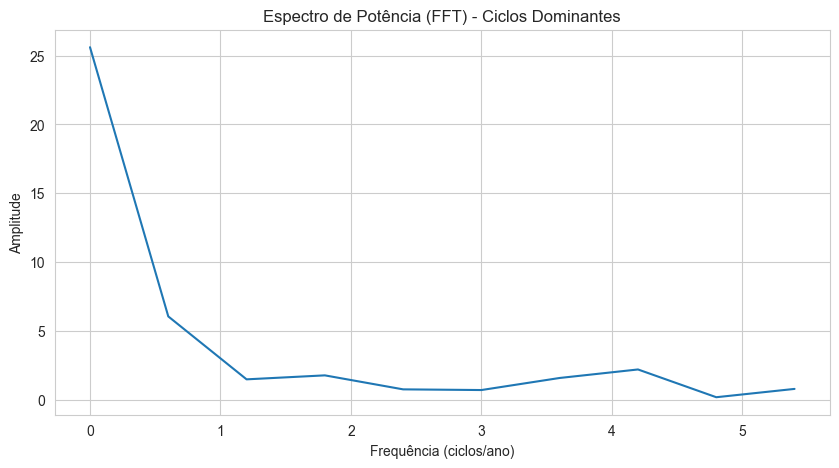

Insight: Picos no gráfico indicam a frequência da sazonalidade (ex: 1.0 = anual, 2.0 = semestral).


In [15]:
# 1.2 Análise de Fourier (FFT) - Identificando Ciclos Ocultos
signal = df_prod['qty'].values
N = len(signal)
T = 1.0 / 12.0 # Amostragem mensal

yf = fft(signal)
xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(10, 5))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color=colors_default[4])
plt.title("Espectro de Potência (FFT) - Ciclos Dominantes")
plt.xlabel("Frequência (ciclos/ano)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("Insight: Picos no gráfico indicam a frequência da sazonalidade.")

## 2. Física dos Preços: Não-Linearidade (Pearson vs Spearman)
A Lei da Demanda raramente é linear. Vamos comparar correlação linear (Pearson) com correlação de rank/monotônica (Spearman).

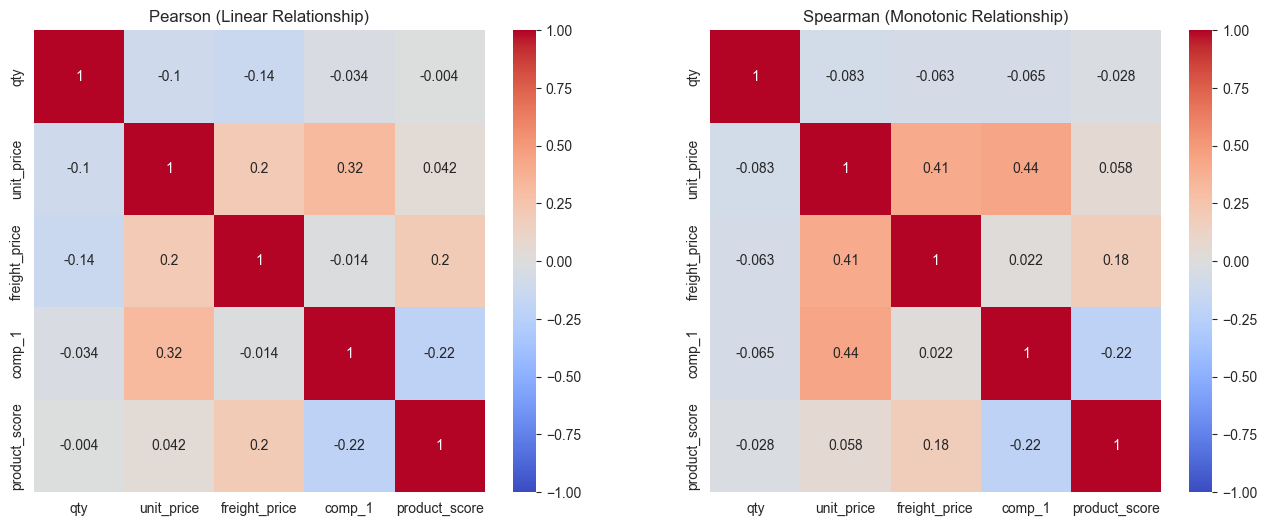

Insight Sênior: Se Spearman > Pearson, a relação existe mas não é uma linha reta (sugere Log-Log ou Árvores).


In [16]:
cols_corr = ['qty', 'unit_price', 'freight_price', 'comp_1', 'product_score']
corr_pearson = df[cols_corr].corr(method='pearson')
corr_spearman = df[cols_corr].corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Pearson (Linear Relationship)')

sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Spearman (Monotonic Relationship)')

plt.show()

print("Insight Sênior: Se Spearman > Pearson, a relação existe mas não é uma linha reta (sugere Log-Log ou Árvores).")

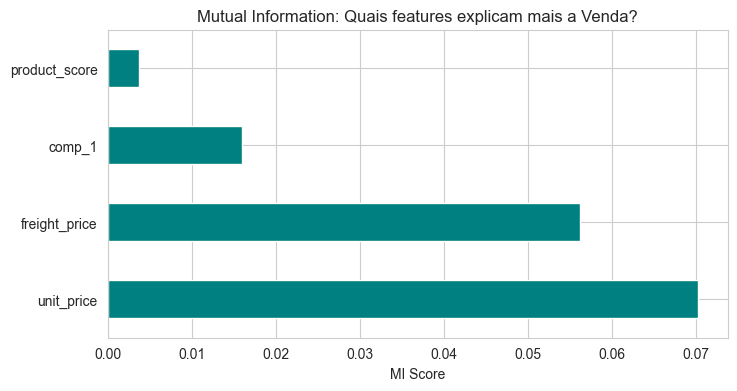

In [17]:
# 2.1 Mutual Information (Teoria da Informação)
# Captura qualquer tipo de dependência (não apenas monotônica)

# Preparar dados (remover NaNs para MI)
df_mi = df[cols_corr].dropna()
X_mi = df_mi.drop('qty', axis=1)
y_mi = df_mi['qty']

mi_scores = mutual_info_regression(X_mi, y_mi, random_state=42)
mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
mi_series.plot(kind='barh', color='teal')
plt.title("Mutual Information: Quais features explicam mais a Venda?")
plt.xlabel("MI Score")
plt.show()

## 3. Inferência Causal (Granger & Cross-Correlation)
Investigando a precedência temporal: O preço do concorrente cair HOJE afeta minha venda AMANHÃ?

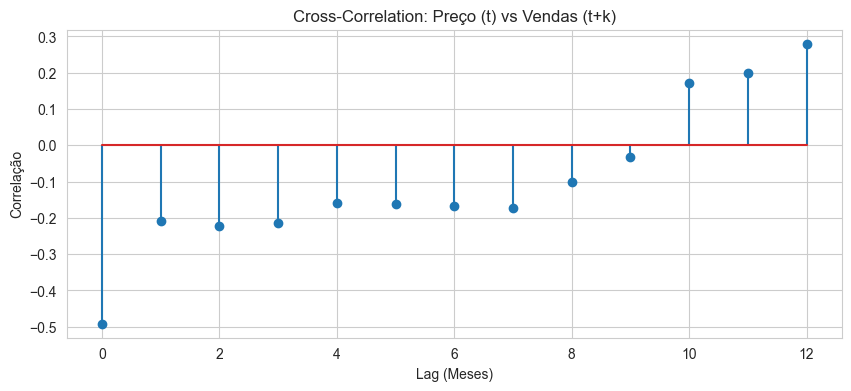

Interpretação: Um pico negativo no Lag 1 sugere que o aumento de preço leva 1 mês para impactar a demanda.


In [18]:
# 3.1 Cross-Correlation Function (CCF)
# Vendas vs Preço Unitário (com Lags)

lags = ccf(df_prod['unit_price'], df_prod['qty'])
plt.figure(figsize=(10, 4))
plt.stem(range(len(lags[:13])), lags[:13])
plt.title('Cross-Correlation: Preço (t) vs Vendas (t+k)')
plt.xlabel('Lag (Meses)')
plt.ylabel('Correlação')
plt.show()

print("Interpretação: Um pico negativo no Lag 1 sugere que o aumento de preço leva 1 mês para impactar a demanda.")

In [19]:
# 3.2 Teste de Causalidade de Granger
# H0: X não causa Y (Precedência temporal)
# Vamos testar: Preço Concorrente (comp_1) -> Minha Venda (qty)?

print("Granger Causality Test: Preço Concorrente causa vendas?")
data_granger = df_prod[['qty', 'comp_1']].dropna()

# O teste exige séries estacionárias. Vamos assumir estacionariedade para EDA rápida ou aplicar diff se necessário
# 'qty' causa 'comp_1'? ou 'comp_1' causa 'qty'? 
# Testaremos lags de 1 a 3 meses
maxlag = 3
try:
    grangercausalitytests(data_granger, maxlag=maxlag, verbose=True)
except Exception as e:
    print(f"Erro no teste (provavelmente dados constantes): {e}")

Granger Causality Test: Preço Concorrente causa vendas?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4411  , p=0.5160  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=0.5238  , p=0.4692  , df=1
likelihood ratio test: chi2=0.5167  , p=0.4722  , df=1
parameter F test:         F=0.4411  , p=0.5160  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3680  , p=0.0663  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=9.3267  , p=0.0094  , df=2
likelihood ratio test: chi2=7.5149  , p=0.0233  , df=2
parameter F test:         F=3.3680  , p=0.0663  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1041  , p=0.1633  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=10.7311 , p=0.0133  , df=3
likelihood ratio test: chi2=8.3188  , p=0.0399  , df=3
parameter F test:         F=2.1041  , p=0.1633  , df_denom=10, df_num=3


## 4. Análise Competitiva: Relative Price Index (RPI)
Elasticidade cruzada: Como minha demanda reage quando sou mais caro que a média do mercado?

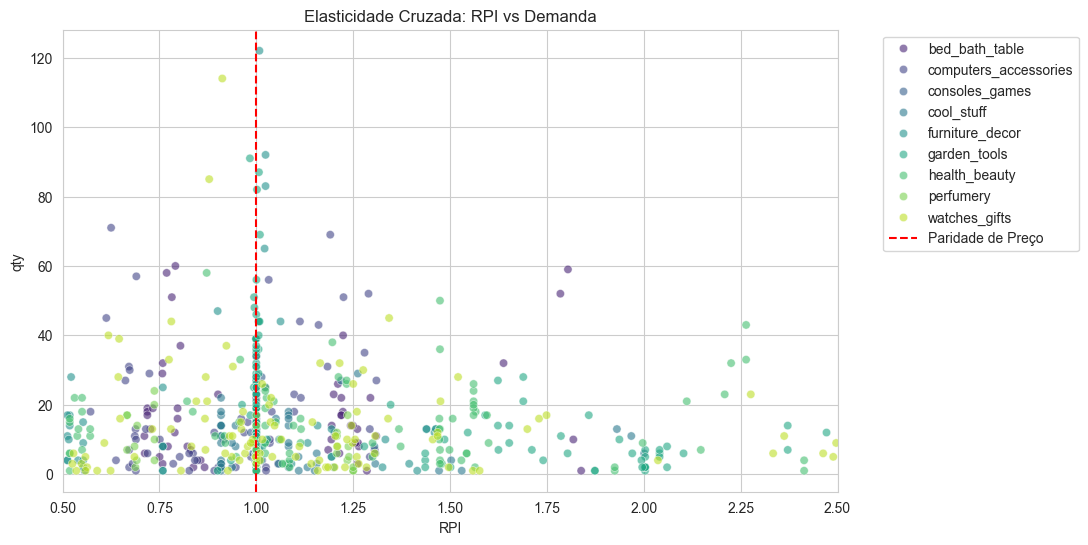

Análise: Produtos à direita da linha vermelha (RPI > 1) sustentam vendas sendo mais caros? Se sim, têm marca forte (premium).


In [20]:
# Criar feature RPI
# RPI > 1.0 : Estou mais caro que a concorrência
# RPI < 1.0 : Estou mais barato

# Média dos concorrentes (comp_1, comp_2, comp_3, ignorando NaNs)
competitor_cols = ['comp_1', 'comp_2', 'comp_3']
df['avg_comp_price'] = df[competitor_cols].mean(axis=1)
df['RPI'] = df['unit_price'] / df['avg_comp_price']

# Scatterplot: RPI vs Demanda
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='RPI', y='qty', hue='product_category_name', alpha=0.6, palette='viridis')
plt.axvline(1.0, color='red', linestyle='--', label='Paridade de Preço')
plt.title("Elasticidade Cruzada: RPI vs Demanda")
plt.xlim(0.5, 2.5) # Focar na região relevante
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print("Análise: Produtos à direita da linha vermelha (RPI > 1) sustentam vendas sendo mais caros? Se sim, têm marca forte (premium).")